In [408]:
from datetime import date, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-poster')
sns.set_theme(context='talk', style='darkgrid')  # poster notebook

In [409]:
def read_yuma(almanac_file):
    ''' 
    Reading and parsing YUMA asci format
    INPUT:
        Almanac: YUMA format 
    OUTPUT:
        almanac_data -  type list of list [strings value], number of lists is equal to number of satellite
                        one list contain satellites according to the order:         
                        ['SV ID', 'Health', 'Eccentricity', 'Time of Applicability(s)', 'Inclination(rad)', 
                        'Rate of Right Ascen(r/s)', 'SQRT(A)  (m 1/2)', 'Right Ascen at Week(rad)', 
                        'Argument of Perigee(rad)', 'Mean Anom(rad)', 'Af0(s)', 'Af1(s/s)', 'Week no']
        
    '''
    
    if almanac_file:
        alm = open(almanac_file)
        
        alm_lines = alm.readlines()
        all_sat = []
        for idx, value in enumerate(alm_lines):
            # print(idx, value)
            
            if value[0:3]=='ID:':
                one_sat_block = alm_lines[idx:idx+13]
                one_sat = []
                for line in one_sat_block:
                    data = line.split(':')
                    one_sat.append(float(data[1].strip()))
                all_sat.append(one_sat)
        alm.close()
        all_sat = np.array(all_sat)
        return (all_sat)  

In [410]:
def date2tow(data):
    """
    Parameters
    data : data -- list [year,month,day,hour,minute,second]
    Returns
    week : GPS week, for the second rollover, in range 0-1023
    tow : second of week.
    """
    # difference of days
    dd = date.toordinal(date(data[0], data[1], data[2])) - date.toordinal(date(2019, 4, 7))    
    # week number
    week = dd // 7
    #day of week
    dow = dd % 7
    # time of week
    tow = dow * 86400 + data[3] * 3600 + data[4] * 60 + data[5]
    return week, tow

In [411]:
def satpos(nav, week, tow):
    """jedna duża funkcja, algorytm na TEAMS, zwracać ma x, y, z"""
    # stałe
    mi = 3.986005e14  # prędkość kątowa obrotu Ziemii - to, czy omge?
    omge = 7.2921151467e-5

    prn = nav[0]
    e = nav[2]
    toa = nav[3]
    i = nav[4]
    Omega_dot = nav[5]
    sqrta = nav[6]
    Omega = nav[7]
    omega = nav[8]
    M0 = nav[9]
    gps_week = nav[12] 

    t = week * 7 * 86400 + tow
    toa_weeks = gps_week * 7 * 86400 + toa

    # tk = tow - toa
    tk = t - toa_weeks
    # print(tk)  # print(tk/86400)

    # Krok 2 algorytmu
    a = sqrta**2
    n = np.sqrt(mi/(a**3))
    Mk = M0 + n * tk
    # Ek = Mk + e * np.sin(EK)  # rozwiazanie iteracyjne
    Epop = Mk
    while True:
        E = Mk + e * np.sin(Epop)
        # print(E)
        if (abs(E-Epop)<10**(-12)):
            break
        Epop = E
    Ek = E
    # atan2 z math lub arctan2 z numpy
    vk = np.arctan2(np.sqrt(1 - e**2)*np.sin(Ek) , np.cos(Ek)-e)
    Fik = vk + omega
    rk = a * (1 - e * np.cos(Ek))
    xk = rk * np.cos(Fik)
    yk = rk * np.sin(Fik)
    # na dole toa czy toa_weeks?
    Omega_k = Omega + (Omega_dot - omge) * tk - omge * toa  # skąd omega_E?
    Xk = xk * np.cos(Omega_k) - yk * np.cos(i) * np.sin(Omega_k)
    Yk = xk * np.sin(Omega_k) + yk * np.cos(i) * np.cos(Omega_k)
    Zk = yk * np.sin(i)
    return np.array([Xk, Yk, Zk])

In [412]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianach do wzorów, do fcji w deg"""
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [413]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = B - A
    return rotation_matrix.transpose() @ vector

# Parametry do ustawienia

In [414]:
PLIK = 'yumagood.txt'  # ścieżka do pliku z danymi z almanachu
DATA = [2022, 2, 25, 0, 0, 0]  # data obserwacji
FI_, LAM_, H_ = 52, 21, 100  # współrzędne miejsca obserwacji
MASKA = 10  # elewacja w stopniach

# Obliczenia i wykresy

In [415]:
navall = read_yuma(PLIK)
datak = list(DATA[:])
odbiornik = geo2xyz(FI_, LAM_, H_)

# dict24 = dict(DOP=dict(), test=['test0', 'test1'], widoczne=[])
DOP = dict(GDOP=[], PDOP=[], TDOP=[], HDOP=[], VDOP=[])
ile_widocznych = []
jakie_widoczne = dict()
satelity_neu = dict()
satelity_xyz = dict()
satelity_elaz = []
better_elaz = dict()
elewacje = dict()
elewacje2 = dict()

for i in range(1,25):
    week, tow = date2tow(datak)  ############
    df = pd.DataFrame(navall, columns=['PRN', 'health', 'eccentricity', 'toa', 'oi', 'rora', 'sqrta', 'raaw', 'aop', 'ma', 'af0', 'af1', 'week'])
    xsat = []
    ysat = []
    zsat = []
    xodb = []
    yodb = []
    zodb = []
    nn = []
    ee = []
    uu = []
    az = []
    el = []
    for sat in navall:
        Xs = satpos(sat, week, tow)
        xsat.append(Xs[0])
        ysat.append(Xs[1])
        zsat.append(Xs[2])
        Xr = odbiornik
        xodb.append(Xr[0])
        yodb.append(Xr[1])
        zodb.append(Xr[2])
        # Xsr = Xs - Xr
        neu = xyz2neu(FI_, LAM_, Xr, Xs)
        n, e, u = neu
        nn.append(n)
        ee.append(e)
        uu.append(u)
        Az = np.arctan2(e,n)  # azymut
        ele = np.arcsin(u/np.sqrt(n**2 + e**2 + u**2))  # elewacja
        azst = np.rad2deg(Az)
        elst = np.rad2deg(ele)
        az.append(azst)
        el.append(elst)
    df['xsat'] = xsat
    df['ysat'] = ysat
    df['zsat'] = zsat
    df['xodb'] = xodb
    df['yodb'] = yodb
    df['zodb'] = zodb
    df['n'] = nn
    df['e'] = ee
    df['u'] = uu
    df['az'] = az
    df['el'] = el
    
    df.set_index('PRN', inplace=True)
    df['distance'] = df.apply(lambda row : np.linalg.norm(np.array([row['xsat'], row['ysat'], row['zsat']]) - np.array([row['xodb'], row['yodb'], row['zodb']])), axis=1)
    df['Ax'] = df.apply(lambda row : -(row['xsat'] - row['xodb'])/row['distance'], axis=1)
    df['Ay'] = df.apply(lambda row : -(row['ysat'] - row['yodb'])/row['distance'], axis=1)
    df['Az'] = df.apply(lambda row : -(row['zsat'] - row['zodb'])/row['distance'], axis=1)
    
    maska_df = df[df['el'] > MASKA]
    A = maska_df[['Ax', 'Ay', 'Az']].to_numpy()
    wiersze = maska_df.shape[0]
    ile_widocznych.append(wiersze)  ###
    jakie_widoczne[i-1] = maska_df.index.values ###
    for index, row in maska_df.iterrows():
        lista = [row.n, row.e, row.u]
        try:
            satelity_neu[index].append(lista)
        except KeyError:
            satelity_neu[index] = lista
        temp = [row.xsat, row.ysat, row.zsat]
        try:
            satelity_xyz[index].append(temp)
        except KeyError:
            satelity_xyz[index] = temp
        other = [row.el, row.az]
        try:
            better_elaz[index].append(other)
        except KeyError:
            better_elaz[index] = other
        satelity_elaz.append([index, row.el, row.az])
        
        try:
            elewacje[index]['h'].append(i-1)
            elewacje[index]['el'].append(row.el)
        except KeyError:
            elewacje[index] = dict(h=[i-1], el=[row.el])
    for index, row in df.iterrows():
        try:
            elewacje2[index]['h'].append(i-1)
            elewacje2[index]['el'].append(row.el)
        except KeyError:
            elewacje2[index] = dict(h=[i-1], el=[row.el])
        
    ones = np.array([np.repeat(1, wiersze)])
    A = np.concatenate((A, ones.T), axis=1)
    Q = np.linalg.inv(A.T @ A)
    qx, qy, qz, qt = np.diagonal(Q)
    GDOP = np.sqrt(qx+qy+qz+qt)
    PDOP = np.sqrt(qx+qy+qz)
    TDOP = np.sqrt(qt)
    fi = np.deg2rad(FI_)
    lam = np.deg2rad(LAM_)
    R = np.array([
        [-np.sin(fi)*np.cos(lam), -np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]])
    Qxyz = Q[:-1,:-1]
    Qneu = R.T @ Qxyz @ R
    qn, qe, qu = np.diagonal(Qneu)
    HDOP = np.sqrt(qn+qe)
    VDOP = np.sqrt(qu)
    DOP['GDOP'].append(GDOP)  ###
    DOP['PDOP'].append(PDOP)  ###
    DOP['TDOP'].append(TDOP)  ###
    DOP['HDOP'].append(HDOP)  ###
    DOP['VDOP'].append(VDOP)  ###
    
    
    datak[3] = i ############
#     print(datak) ############

In [416]:
print('GDOP\n', DOP['GDOP'])
print('\nPDOP\n', DOP['PDOP'])
print('\nTDOP\n', DOP['TDOP'])
print('\nHDOP\n', DOP['HDOP'])
print('\nVDOP\n', DOP['VDOP'])

GDOP
 [2.2881065941826875, 1.8998747724291056, 1.848486928868121, 1.934246847836042, 2.172451212840377, 2.180080846761741, 1.9952418502565867, 2.589499054767193, 1.675113021279894, 2.1443726153829186, 2.1814093668890755, 1.7257013584070187, 1.9731594917541615, 2.228326425101555, 1.7672277247271204, 1.9920711655016143, 2.477777325986273, 1.8800047968772806, 2.449809392600222, 2.313453053501213, 1.6681870273799984, 1.9198772149292194, 2.020800594859434, 1.9606508464578647]

PDOP
 [1.9802088005866127, 1.6894516605812666, 1.6422257397419797, 1.7152973151414221, 1.9168697346514096, 1.9373049769224373, 1.7572242265976323, 2.238108887724863, 1.4983526217001064, 1.93490389111254, 1.9604329103244187, 1.55724606823633, 1.7614779214622016, 1.9534938287772936, 1.6061845202417346, 1.7527471943930253, 2.166995142388692, 1.6685252513625437, 2.1246110881059894, 2.0005356343503813, 1.488518071170936, 1.7071202559492875, 1.7679769913933305, 1.7155396983940856]

TDOP
 [1.1463877583181123, 0.8690668774448

In [417]:
## print(ile_widocznych)

In [418]:
# print(jakie_widoczne)  # bar plot / histogram ... k - godziny od podanej daty, v - numery satelit

In [419]:
# print(satelity_neu)  # k - numery satelit, v - [neu]

In [420]:
# print(satelity_xyz)  # k - numery satelit, v - [xyz]

In [421]:
# print(sorted(satelity_elaz))  # [NR, EL, AZ]

In [422]:
# print(better_elaz)  # k - numery satelit

In [423]:
## print(elewacje2)  # k - numery satelit, v - {h:[], el:[]}

## Elewacje

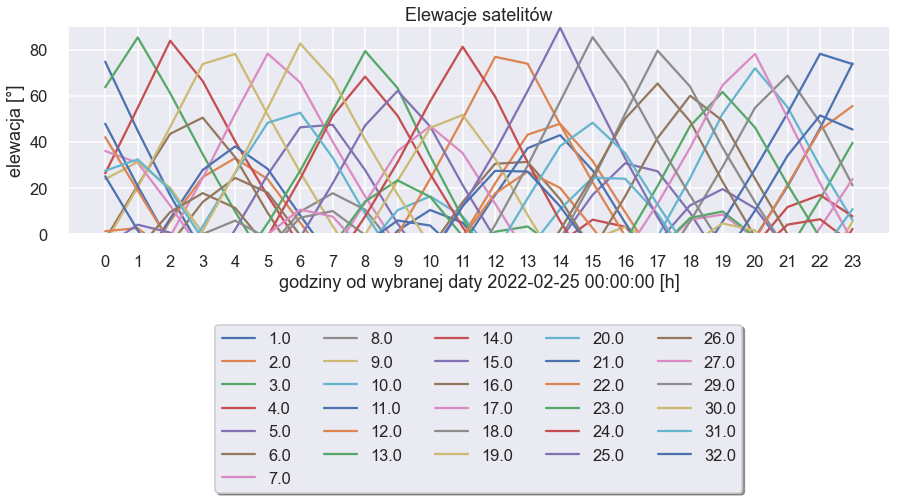

In [424]:
sns.set_theme(context='talk', style='darkgrid')  # style=ticks white 
for k, v in elewacje2.items():
    plt.plot(v['h'], v['el'], label=k)
    
plt.title('Elewacje satelitów')
plt.ylabel('elewacja [°]')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
ax = plt.gca()
ax.set_ylim([0, 90])
# Legenda do wywalenia raczej
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [425]:
numeryy = []
godzinyy = []
elewacjee = []
for prn, v in elewacje2.items():
    godzinyy.extend(v['h'])
    elewacjee.extend(v['el'])
    for i in range(len(v['h'])):
        numeryy.append(prn)
eledf = pd.DataFrame(list(zip(numeryy, godzinyy, elewacjee)), columns=['PRN', 'h', 'el'])

In [426]:
fig = px.line(eledf, x='h', y='el', color='PRN',title='Elewacje satewlitów', labels={'h':'godzina od wybranej daty','el':'elewacja [°]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.update_xaxes(showspikes=True)
# fig.update_yaxes(showspikes=True)
fig.show()

## Liczba widocznych satelitów

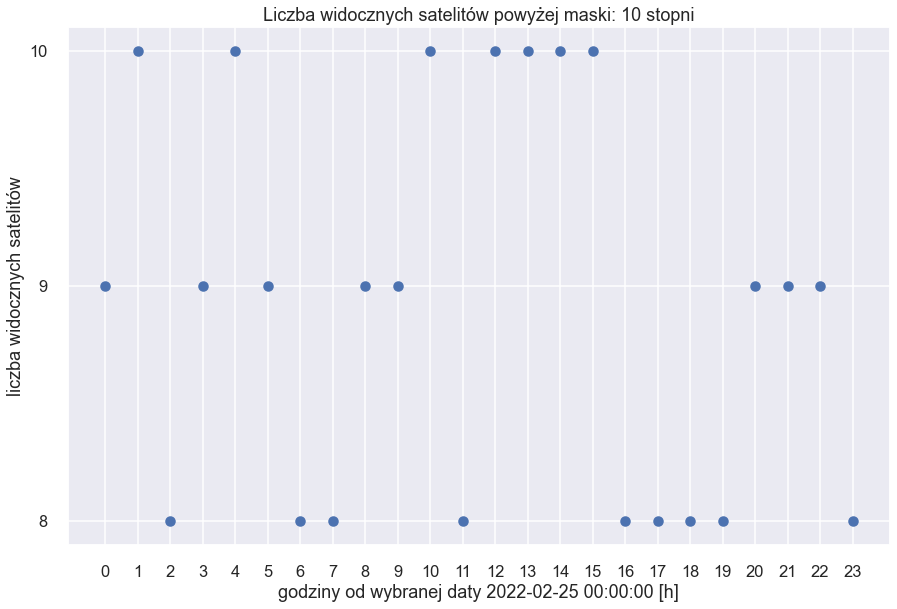

In [427]:
plt.scatter(range(0,24),ile_widocznych)   
plt.title('Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni')
plt.ylabel('liczba widocznych satelitów')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(min(ile_widocznych),max(ile_widocznych)+1))
plt.tight_layout()
plt.show()

## Współczynniki DOP